<a href="https://colab.research.google.com/github/Waleed-Mujahid/Fast-Gradient-Sign-method/blob/main/FGSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Fast Gradient sign Menthod
In this notebook I generate adversial images using the fast gradient sign method introduced in *"Explaining and Harnessing Adversarial Examples"* by [Goodfellow et al]. 


---

I have taken a tiny version of the Food-101 dataset with 10 classes with 200 images each (150 training and 50 test images).
I use a pre-trained Efficient-B0 model to train on the dataset. Then I use the Fast gradient sign method to generate adversial images to fool the classifier.

## Import Dependecies

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import keras 
from keras.layers import Dense, Conv2D, InputLayer, MaxPooling2D, Flatten, Input,Dropout,BatchNormalization
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
import cv2
import random,os

here I import some helper functions

In [2]:
from colabUtils import *

In [1]:
!wget https://raw.githubusercontent.com/Waleed-Mujahid/Coding/master/colabUtils.py

--2022-07-29 19:53:13--  https://raw.githubusercontent.com/Waleed-Mujahid/Coding/master/colabUtils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2206 (2.2K) [text/plain]
Saving to: ‘colabUtils.py’

colabUtils.py       100%[===================>]   2.15K  --.-KB/s    in 0s      

2022-07-29 19:53:13 (42.9 MB/s) - ‘colabUtils.py’ saved [2206/2206]



## Loading our dataset from kaggle

In [85]:
! pip install kaggle

In [77]:
! mkdir ~/.kaggle

First you need to download your API credentials from kaggle. You will get a kaggle.json file. Upload it below

In [78]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [79]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [80]:
! kaggle datasets download -d msarmi9/food101tiny

 97% 93.0M/96.1M [00:00<00:00, 129MB/s]
100% 96.1M/96.1M [00:00<00:00, 129MB/s]


In [83]:
!unzip -q /content/food101tiny.zip

## Visualizing our Dataset
Now lets use one of the helper functions to visualize the data.

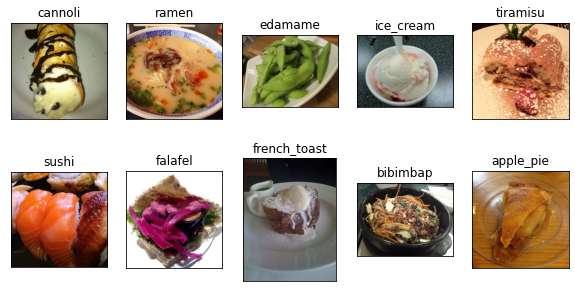

In [84]:
visualizeData('/content/data/food-101-tiny/train', (2,5))

As the images in the dataset do not have the same size so we need to bring them to the same size. We can do this with ImageDataGenerator from keras. We can also use it to augment and normalize our data.

In [89]:
image_shape = (224,224)

In [14]:
train_datagen = ImageDataGenerator( 
rescale=1. / 255,
rotation_range = 20,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1. / 255
)

In [15]:
train_dir = '/content/data/food-101-tiny/train'
test_dir = '/content/data/food-101-tiny/valid'

In [88]:
num_classes = len(os.listdir(train_dir))

In [16]:
train_generator = train_datagen.flow_from_directory(train_dir,batch_size = 32, target_size = image_shape)
validation_generator = test_datagen.flow_from_directory(test_dir,batch_size = 32, target_size = image_shape)

Found 1500 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


## Transfer Learning
Next we take a Efficient-B0 trained on imagenet and fine tune it to our dataset.

In [99]:
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=False)
base_model.trainable = False                 # The model is pre-trained, we do not want to train it
model = Sequential()
model.add(base_model)

# next we add some layers of our own
model.add(Conv2D(128, (5, 5), padding = 'same'))
model.add(keras.layers.Activation('relu'))
model.add(Conv2D(128, (5, 5), padding = 'same' ))
model.add(keras.layers.Activation('relu'))
model.add(MaxPooling2D(strides=2))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), padding = 'same'))
model.add(keras.layers.Activation('relu'))
model.add(Conv2D(64, (3, 3), padding = 'same' ))
model.add(keras.layers.Activation('relu'))
model.add(MaxPooling2D(strides=2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(num_classes,activation='softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_28 (Conv2D)          (None, 7, 7, 128)         4096128   
                                                                 
 activation_28 (Activation)  (None, 7, 7, 128)         0         
                                                                 
 conv2d_29 (Conv2D)          (None, 7, 7, 128)         409728    
                                                                 
 activation_29 (Activation)  (None, 7, 7, 128)         0         
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 3, 3, 128)        0         
 g2D)                                                 

In [100]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
metrics=['accuracy'])

In [101]:
history = model.fit(train_generator, batch_size = 32, epochs = 20, validation_data = validation_generator, callbacks = [lr_scheduler])

Epoch 1/20
47/47 [==============================] - 29s 577ms/step - loss: 2.1943 - accuracy: 0.2007 - val_loss: 1.6865 - val_accuracy: 0.4760 - lr: 1.0000e-04
Epoch 2/20
47/47 [==============================] - 26s 557ms/step - loss: 1.5622 - accuracy: 0.4347 - val_loss: 1.1421 - val_accuracy: 0.6720 - lr: 1.0000e-04
Epoch 3/20
47/47 [==============================] - 22s 467ms/step - loss: 1.1375 - accuracy: 0.6080 - val_loss: 0.8672 - val_accuracy: 0.7280 - lr: 1.0000e-04
Epoch 4/20
47/47 [==============================] - 23s 494ms/step - loss: 0.9367 - accuracy: 0.6987 - val_loss: 0.7696 - val_accuracy: 0.7480 - lr: 1.0000e-04
Epoch 5/20
47/47 [==============================] - 22s 468ms/step - loss: 0.7217 - accuracy: 0.7707 - val_loss: 0.6728 - val_accuracy: 0.7900 - lr: 1.0000e-04
Epoch 6/20
47/47 [==============================] - 31s 664ms/step - loss: 0.6337 - accuracy: 0.7953 - val_loss: 0.7159 - val_accuracy: 0.7800 - lr: 1.0000e-04
Epoch 7/20
47/47 [======================

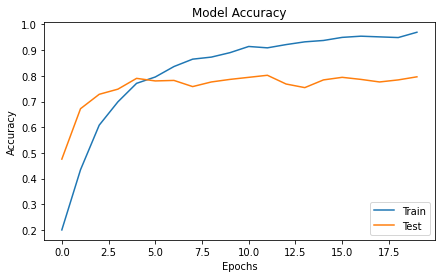

In [113]:
plotAccuracy(history,True)

Now lets have a look at our model's performance.

In [111]:
loss, accuracy_nn = model.evaluate(validation_generator)
print(f"The accuracy received on Test data is: {accuracy_nn*100:.2f}%")

16/16 [==============================] - 2s 143ms/step - loss: 0.9172 - accuracy: 0.7960
The accuracy received on Test data is: 79.60%


# Fast Gradient sign method
Now we make the implementation of the fast gradient sign method.


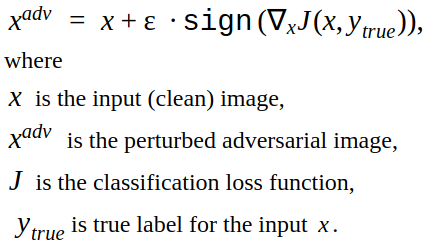

In [103]:
def fgsm(input_img, model, eps, loss_fn, y_true):
  y_true = tf.one_hot(y_true,10)
  y_true = tf.reshape(y_true, (1, 10))

  with tf.GradientTape() as tape:
    tape.watch(input_img)
    logit = model(input_img)
    loss = loss_fn(y_true,logit) # loss/ cost between true label versus predicted label

  grad = tape.gradient(loss,input_img) # Derivative of the loss with respect to the orignal image
  perturbation = tf.sign(grad)
  adv_img = input_img + eps * perturbation
  adv_img = np.clip(adv_img, 0, 1)
  return adv_img

## Fooling the model on Test set
Now we add perturbation from the FGSM to checks how much accuracy falls.


In [119]:
file_path = '/content/data/food-101-tiny/valid'
label = []
data = []
labels = validation_generator.class_indices

for dir in os.listdir(file_path):
  label_val = labels[dir]
  img_path = os.path.join(file_path, dir)
  for img in os.listdir(img_path):
    img = tf.io.read_file(os.path.join(img_path, img))
    img = tf.image.decode_image(img, channels = 3)
    test_img = tf.image.resize(img, size = image_shape)    # Resize the image according to the model
    test_img = test_img/255.
    data.append(test_img)
    label.append(label_val)

In [120]:
data = np.asarray(data)
label = np.asarray(label)

In [121]:
epsilon = 0.01
loss = tf.keras.losses.categorical_crossentropy
adv_pred = []


for idx,img in enumerate(data):
  adv_img = fgsm(tf.expand_dims((img),axis=0), model, epsilon, loss, label[idx])
  pred = np.argmax(model.predict(adv_img))
  adv_pred.append(pred)

In [122]:
from sklearn.metrics import accuracy_score

pred = model.predict_on_batch(data)
pred = np.argmax(pred,axis=1)
accuracy = accuracy_score(label,pred)
adversial_batch_accuracy = accuracy_score(label,adv_pred)
print(f'Accuracy of classifier on clean test set = {accuracy*100:.2f}')
print(f'Accuracy of classifier on test set after adding perturbation = {adversial_batch_accuracy*100:.2f}')

Accuracy of classifier on clean test set = 80.00
Accuracy of classifier on test set after adding perturbation = 7.40


In [108]:
name_labels = validation_generator.class_indices
index_labels = {value:key for key, value in name_labels.items()}

## Visualizing Orignal and Adversial images
Let us compare the adversial images and orignal images side by side.

In [109]:
parent_dir = '/content/data/food-101-tiny/train'
paths = []
lab = []

for dir in os.listdir(parent_dir):
  p_dir = parent_dir + '/' + dir
  paths.append(p_dir + '/' + random.choice(os.listdir(p_dir)))
  lab.append(dir)

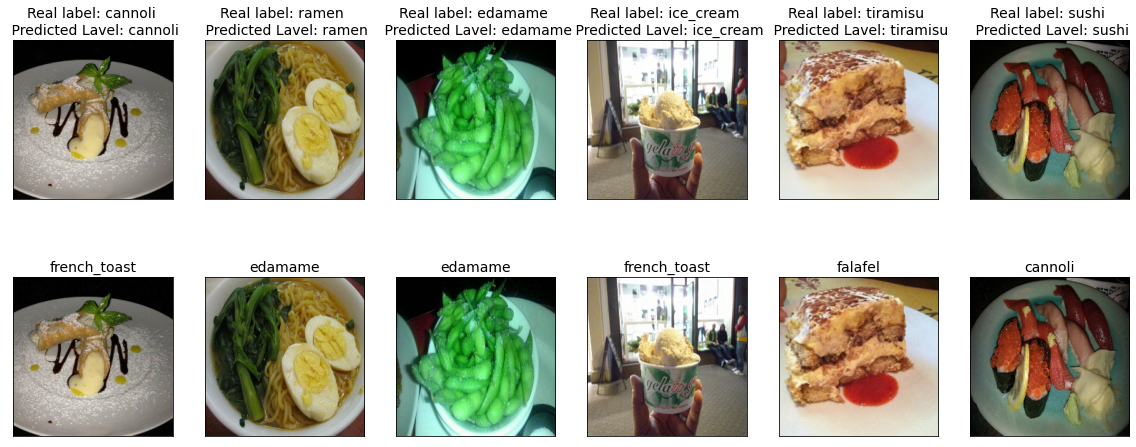

In [127]:
count = 1
epsilon = 0.01
loss = tf.keras.losses.categorical_crossentropy

plt.figure(figsize = (20,8))
for i in range(6):
  image = tf.expand_dims(processImg(paths[i], image_shape),axis=0)
  plt.subplot(2,6,count)
  plt.imshow(image[0])
  plt.xticks([])             # Disabling ticks
  plt.yticks([])
  pred = model.predict(image)
  label = index_labels[pred.argmax()]
  plt.title(f"Real label: {lab[i]} \n Predicted Lavel: {label}", fontsize = 14)

  adv_img = fgsm(image,model,epsilon,loss, name_labels[lab[i]])
  plt.subplot(2,6,count+6)
  plt.imshow(adv_img[0])
  plt.xticks([])         
  plt.yticks([])
  pred = model.predict(adv_img)
  label = index_labels[pred.argmax()]
  plt.title(label, fontsize = 14)
  count += 1

So we can see from the above plot that there is very minimal differnece between the orignal images and the adversial images. Stil, the accuracy of the classifier dropped from 80% to 7.4%. This is the power of adverisal attacks.